<a href="https://colab.research.google.com/github/nasarmientoo/diq_boston_crimes/blob/main/Data_Profiling%2C_Quality_Assessment%2C_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import** **libraries**

In [4]:
# Install necessary libraries in Google Colab
!pip install -q ydata-profiling fuzzywuzzy matplotlib seaborn sweetviz lux-api autoviz plotly

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from fuzzywuzzy import process, fuzz
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.0/127.0 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 32.0 MB/s

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# **Data Loading**

In [5]:
# Load datasets from Google Drive
# Load the main crime dataset
crime_data = pd.read_csv('/content/drive/MyDrive/DQ/crime.csv', encoding='unicode_escape')
# Load the offense codes dataset
offense_codes = pd.read_csv('/content/drive/MyDrive/DQ/offense_codes.csv', encoding='unicode_escape')

## Data Preparation

In [10]:
# Merge datasets to include offense descriptions
# This step ensures that each crime entry has a detailed description of the offense type
# Check if the column name is "INCIDENT_NUMBER" (based on the global variables)
crime_data = pd.merge(crime_data, offense_codes, left_on="OFFENSE_CODE", right_on="CODE", how="inner")

### Preview Data Profiling

In [11]:
# Generate an initial data profiling report to understand the structure and quality of the data
profile = ProfileReport(crime_data, title="Initial Crime Data Profiling Report", explorative=True)
profile.to_file("initial_crime_data_report.html")

# Use Sweetviz for additional data profiling
import sweetviz as sv
report = sv.analyze(crime_data)
report.show_html("sweetviz_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# **Data Cleaning**

### Data Standardization

In [12]:
# Standardize column names to lowercase for consistency
crime_data.columns = crime_data.columns.str.lower()

# Convert 'occurred_on_date' column to a datetime format for easier temporal analysis
crime_data['occurred_on_date'] = pd.to_datetime(crime_data['occurred_on_date'], errors='coerce')

# Standardize text data by stripping whitespace and converting to lowercase
text_columns = crime_data.select_dtypes(include='object').columns
crime_data[text_columns] = crime_data[text_columns].apply(lambda x: x.str.strip().str.lower())

### Detection and Correction of Error

In [14]:
# Summarize missing values to identify columns requiring attention
missing_summary = crime_data.isnull().sum()
print("Missing Values Summary:\n", missing_summary)

# Drop rows with critical missing values in key columns ('occurred_on_date', 'offense_code', 'district')
crime_data = crime_data.dropna(subset=['occurred_on_date', 'offense_code', 'district'])

# Impute missing values in 'shooting' column with 'n', assuming 'n' denotes 'no shooting'
crime_data['shooting'].fillna('n', inplace=True)

# Detect and handle outliers in latitude and longitude columns using z-scores
crime_data[['lat', 'long']] = crime_data[['lat', 'long']].apply(pd.to_numeric, errors='coerce')
# Calculate z-scores on the non-missing values only
z_scores = np.abs(zscore(crime_data[['lat', 'long']].dropna()))
# Filter the original DataFrame based on the index of the non-missing values
outliers_index = crime_data[['lat', 'long']].dropna().index[np.where((z_scores > 3).all(axis=1))]
# Remove outliers from the original DataFrame
crime_data = crime_data.drop(index=outliers_index)

Missing Values Summary:
 incident_number            0
offense_code               0
offense_code_group         0
offense_description        0
district                   0
reporting_area             0
shooting                   0
occurred_on_date           0
year                       0
month                      0
day_of_week                0
hour                       0
ucr_part                  94
street                 15949
lat                    32048
long                   32048
location                   0
code                       0
name                       0
dtype: int64


### Data Deduplication

In [15]:
# Map 'ucr_part' values to numerical codes for consistent comparison
ucr_part_map = {
    'part one': 1,
    'part two': 2,
    'part three': 3
}
crime_data['ucr_part_num'] = crime_data['ucr_part'].map(ucr_part_map).fillna(0).astype(int)

# Detect exact duplicates based on all columns
exact_duplicates = crime_data.duplicated()
print(f"Number of exact duplicate rows: {exact_duplicates.sum()}")

# Remove exact duplicates, keeping the first occurrence
crime_data = crime_data.drop_duplicates()

# Define a function to detect non-exact duplicates using fuzzy matching
# This function identifies similar entries in a specified column

def find_close_matches(df, column, threshold=90):
    unique_values = df[column].dropna().unique()
    matches = []
    for value in unique_values:
        match = process.extractOne(value, unique_values, scorer=fuzz.token_sort_ratio)
        if match[1] >= threshold and value != match[0]:
            matches.append((value, match[0]))
    return matches

# Example: Finding close matches in 'offense_description'
if 'offense_description' in crime_data.columns:
    close_matches = find_close_matches(crime_data, 'offense_description')
    print(f"Potential non-exact duplicates in 'offense_description':\n{close_matches}")

# Identify duplicates based on a combination of columns for better precision
duplicates = crime_data[crime_data.duplicated(subset=['incident_number', 'ucr_part_num'], keep=False)]
print(f"Detailed duplicates based on offense parts:\n{duplicates}")

# Save cleaned data back to Google Drive for further use
crime_data.to_csv('/content/drive/MyDrive/DQ/cleaned_crime_data.csv', index=False)

Number of exact duplicate rows: 163667
Potential non-exact duplicates in 'offense_description':
[]
Detailed duplicates based on offense parts:
       incident_number  offense_code                offense_code_group  \
0           i182070945           619                           larceny   
1           i182070945           619                           larceny   
15          i182070931           301                           robbery   
16          i182070931           301                           robbery   
33          i182070918          3305  assembly or gathering violations   
...                ...           ...                               ...   
577863   i080542626-00          1848                    drug violation   
577864   i080542626-00          1848                    drug violation   
577865   i080542626-00          1849                    drug violation   
577872   i030217815-08           111                          homicide   
577873   i030217815-08           111       

# Additional Data Quality Assessment

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summary statistics for key columns:
                year          month   ucr_part_num
count  410993.000000  410993.000000  410993.000000
mean     2016.548440       6.620003       2.086795
std         1.001104       3.272902       0.830723
min      2015.000000       1.000000       0.000000
25%      2016.000000       4.000000       1.000000
50%      2017.000000       7.000000       2.000000
75%      2017.000000       9.000000       3.000000
max      2018.000000      12.000000       3.000000
Correlation matrix for numerical columns:
              offense_code      year     month      hour       lat      long  \
offense_code      1.000000  0.042597 -0.017582 -0.016853 -0.084234 -0.028500   
year              0.042597  1.000000 -0.384787  0.001818 -0.007550 -0.001815   
month            -0.017582 -0.384787  1.000000  0.002381  0.006998 -0.000900   
hour             -0.016853  0.001818  0.002381  1.000000 -0.024639 -0.009854   
lat              -0.084234 -0.007550  0.006998 -0.024639  1.000

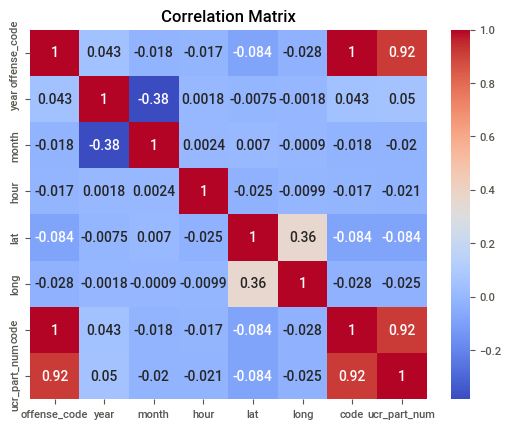

In [17]:
# Generate a new profiling report for the cleaned dataset
cleaned_profile = ProfileReport(crime_data, title="Cleaned Crime Data Profiling Report", explorative=True)
cleaned_profile.to_file("cleaned_crime_data_report.html")

# Summary Statistics for Enhanced Analysis
# Print summary statistics for key numerical columns
print("Summary statistics for key columns:")
print(crime_data[['year', 'month', 'ucr_part_num']].describe())

# Correlation analysis for numerical columns to identify relationships
# Select only numerical features for correlation analysis
numerical_features = crime_data.select_dtypes(include=np.number).columns
correlation_matrix = crime_data[numerical_features].corr()

print("Correlation matrix for numerical columns:")
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()